In [2]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np
from scipy.io import loadmat
import cv2

# from extract_features import extract_features
# from check_webers_law import check_webers_law
# from layerwise_mi_figures import layerwise_mi_figures


/tmp/ipykernel_6642/3221208535.py:10: UserWarning: A NumPy version >=1.22.4 and <1.29.0 is required for this version of SciPy (detected version 1.22.0)
  from scipy.io import loadmat


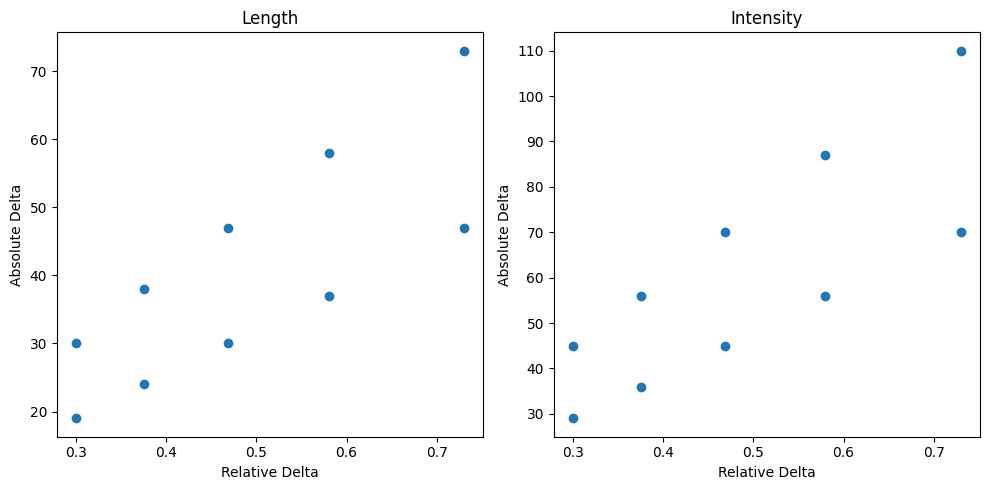

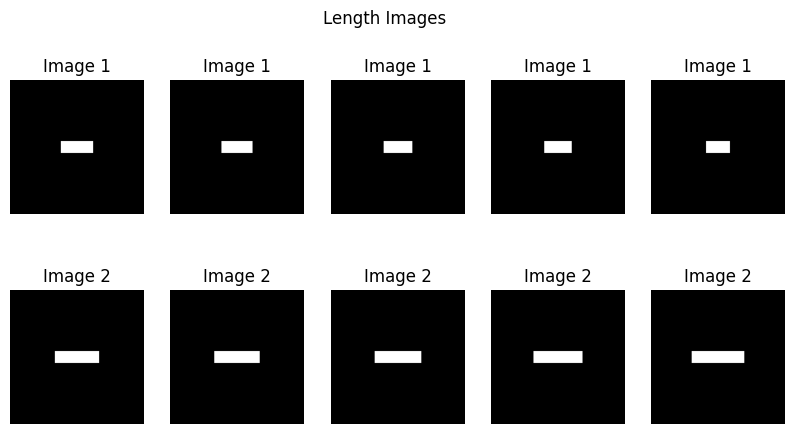

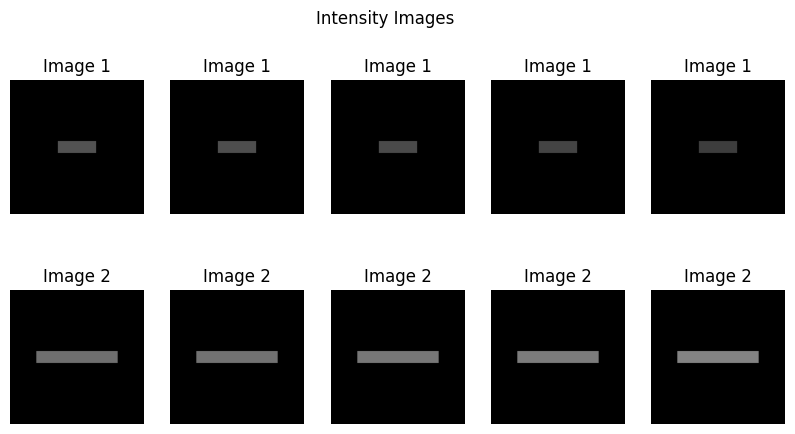

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Length
baseline_length = [64, 100]
r_length = [0.3000, 0.3750, 0.4688, 0.5800, 0.7300]
bar_width = 20
images_length = []
absolute_delta_length = []
relative_delta_length = []

for baseline in baseline_length:
    for r in r_length:
        delta = round(baseline * r)
        if delta % 2 == 1:
            delta1 = delta // 2
            delta2 = delta // 2 + 1
        else:
            delta1 = delta // 2
            delta2 = delta // 2

        bar_length1 = baseline - delta1
        bar_length2 = baseline + delta2

        img1 = np.zeros((224, 224, 3), dtype=np.uint8)
        img1[112 - bar_width // 2: 112 + bar_width // 2, 112 - bar_length1 // 2: 112 + bar_length1 // 2] = [255, 255, 255]
        img2 = np.zeros((224, 224, 3), dtype=np.uint8)
        img2[112 - bar_width // 2: 112 + bar_width // 2, 112 - bar_length2 // 2: 112 + bar_length2 // 2] = [255, 255, 255]

        images_length.append((img1, img2))
        relative_delta_length.append(r)
        absolute_delta_length.append(delta)

# Intensity
baseline_intensity = [96, 150]
r_intensity = [0.3000, 0.3750, 0.4688, 0.5800, 0.7300]
images_intensity = []
absolute_delta_intensity = []
relative_delta_intensity = []

for baseline in baseline_intensity:
    for r in r_intensity:
        delta = round(baseline * r)
        if delta % 2 == 1:
            delta1 = delta // 2
            delta2 = delta // 2 + 1
        else:
            delta1 = delta // 2
            delta2 = delta // 2

        img1 = np.zeros((224, 224, 3), dtype=np.uint8)
        img1[112 - bar_width // 2: 112 + bar_width // 2, 112 - bar_length1 // 2: 112 + bar_length1 // 2] = [baseline - delta1, baseline - delta1, baseline - delta1]
        img2 = np.zeros((224, 224, 3), dtype=np.uint8)
        img2[112 - bar_width // 2: 112 + bar_width // 2, 112 - bar_length2 // 2: 112 + bar_length2 // 2] = [baseline + delta2, baseline + delta2, baseline + delta2]

        images_intensity.append((img1, img2))
        relative_delta_intensity.append(r)
        absolute_delta_intensity.append(delta)

# Save data
np.savez('webers_images_GJ.npz', images_length=images_length, relative_delta_length=relative_delta_length, absolute_delta_length=absolute_delta_length,
                                  images_intensity=images_intensity, relative_delta_intensity=relative_delta_intensity, absolute_delta_intensity=absolute_delta_intensity)

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(relative_delta_length, absolute_delta_length)
plt.xlabel('Relative Delta')
plt.ylabel('Absolute Delta')
plt.title('Length')

plt.subplot(1, 2, 2)
plt.scatter(relative_delta_intensity, absolute_delta_intensity)
plt.xlabel('Relative Delta')
plt.ylabel('Absolute Delta')
plt.title('Intensity')

plt.tight_layout()
plt.show()

# Plot the images
plt.figure(figsize=(10, 5))

for i in range(5):  # Plot first 5 images for each type
    plt.subplot(2, 5, i+1)
    plt.imshow(images_length[i][0])
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(images_length[i][1])
    plt.title('Image 2')
    plt.axis('off')

plt.suptitle('Length Images')
plt.show()

plt.figure(figsize=(10, 5))

for i in range(5):  # Plot first 5 images for each type
    plt.subplot(2, 5, i+1)
    plt.imshow(images_intensity[i][0])
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(images_intensity[i][1])
    plt.title('Image 2')
    plt.axis('off')

plt.suptitle('Intensity Images')
plt.show()


In [4]:
import numpy as np
from scipy.stats import pearsonr

def check_webers_law(features, absolute_delta, relative_delta, dist_type):
    # print(absolute_delta, relative_delta)
    features = np.reshape(features, (len(absolute_delta), 2,-1))

    nL = len(features[0][0]) # Skipping the last layers
    # print(nL)
    COND = len(features)  # conditions
    r_absolute = np.zeros(nL)  # absolute correlation
    r_relative = np.zeros(nL)  # relative correlation
    FD = np.zeros((COND, nL))
    
    for L in range(nL):
        for c in range(COND):
            f1 = np.array(features[c, 0][L])
            f2 = np.array(features[c, 1][L])   
            FD[c, L] = distance_calculation(f1, f2, dist_type)

        r_absolute[L] = pearsonr(FD[:, L], absolute_delta)[0]
        r_relative[L] = pearsonr(FD[:, L], relative_delta)[0]
    # print(FD)

    return r_relative, r_absolute

def distance_calculation(f1, f2, dist_type):
    if dist_type == 'Euclidean':
        return np.linalg.norm(f1 - f2)
    elif dist_type == 'Cosine':
        return np.dot(f1, f2) / (np.linalg.norm(f1) * np.linalg.norm(f2))
    else:
        raise ValueError("Invalid distance type. Choose 'Euclidean' or 'Cosine'.")


In [5]:
stim_data = np.load('webers_images_GJ.npz', allow_pickle=True)
# print(stim_data.keys())
stim_length = stim_data['images_length']
absolute_delta_L = stim_data['absolute_delta_length']
relative_delta_L = stim_data['relative_delta_length']
stim_intensity = stim_data['images_intensity']
absolute_delta_I = stim_data['absolute_delta_intensity']
relative_delta_I = stim_data['relative_delta_intensity']
print(stim_length[0][0].shape)


(224, 224, 3)


In [6]:

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

/home/venix/miniconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/venix/miniconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
vgg16_rand = models.vgg16(pretrained=False)

# Randomly initialize the weights of the model
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

# Apply random initialization to the model
vgg16_rand.apply(weights_init)

/home/venix/miniconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/venix/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:23<00:00, 4.36MB/s]


In [10]:
import timm

# Load pre-trained ViT model
timm = timm.create_model('vit_base_patch16_224', pretrained=True)


/home/venix/miniconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import time


# Function to preprocess image
def preprocess_image(image):
    if isinstance(image, np.ndarray):
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image)


def extract_features(data, model):
    model.eval()
    vgg16Features = model.features
    vgg16AvgPool = model.avgpool
    vgg16Linear = model.classifier
    features = []
    for image in data:
        for g in image:
            image_features = []  # List to store features for each layer in current image
            image_tensor = preprocess_image(g).unsqueeze(0)
            with torch.no_grad():
                for layer in vgg16Features:
                    image_tensor = layer(image_tensor)

                    if isinstance(layer, torch.nn.Conv2d):
                        image_features.append(image_tensor)
                   

                image_tensor = torch.flatten(vgg16AvgPool(image_tensor))
        
                for layer in vgg16Linear:
                    image_tensor = layer(image_tensor)
    
                    if isinstance(layer, torch.nn.Conv2d):
                        image_features.append(image_tensor)
            features.append(image_features)
    
    return features




dist_type = 'Euclidean'
time_taken = []
RC_across_layers = []
model = vgg16
features_length = extract_features(stim_length, model)



In [12]:
r_relativeL, r_absoluteL = check_webers_law(features_length, absolute_delta_L, relative_delta_L, "Euclidean")
RC_across_layers.append([r_relativeL, r_absoluteL])
# Intensity
features_intensity = extract_features(stim_intensity, vgg16)
r_relativeI, r_absoluteI = check_webers_law(features_intensity, absolute_delta_I, relative_delta_I, dist_type)
RC_across_layers.append([r_relativeI, r_absoluteI])
# print(RC_across_layers)


/home/venix/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/venix/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [13]:
print(RC_across_layers[0][0] - RC_across_layers[0][1])

[-0.20653733 -0.21618427 -0.21419293 -0.18429153 -0.16558997 -0.1650277
 -0.15674003 -0.11403147 -0.11444462 -0.15244664 -0.12187219 -0.15772405
 -0.15430655]


[-0.20653733 -0.21618427 -0.21419293 -0.18429153 -0.16558997 -0.1650277
 -0.15674003 -0.11403147 -0.11444462 -0.15244664 -0.12187219 -0.15772405
 -0.15430655]


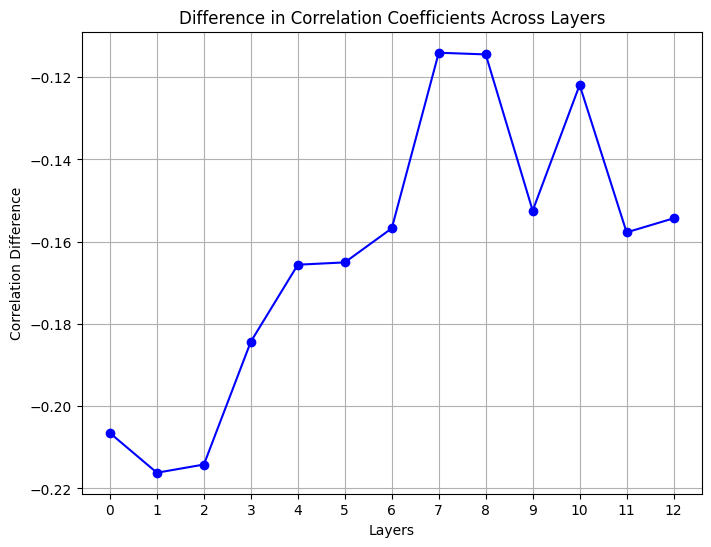

In [14]:
import matplotlib.pyplot as plt

# Assuming RC_across_layers is a list of lists containing correlation coefficients
# where RC_across_layers[i][0] represents one correlation coefficient and
# RC_across_layers[i][1] represents another correlation coefficient for the same layer 'i'

# Compute differences between correlation coefficients across layers
differences = RC_across_layers[0][0] - RC_across_layers[0][1]
print(differences)
# Create x-axis values (layers)
layers = range(len(differences))

# Plot the differences
plt.figure(figsize=(8, 6))
plt.plot(layers, differences, marker='o', linestyle='-', color='b')
plt.xlabel('Layers')
plt.ylabel('Correlation Difference')
plt.title('Difference in Correlation Coefficients Across Layers')
plt.grid(True)
plt.xticks(layers)  # Set x-ticks to be the layer indices
plt.show()


In [17]:
import time


# Function to preprocess image
def preprocess_image(image):
    if isinstance(image, np.ndarray):
        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image)



def extract_features(data, model):
    model.eval()
    features = []
    for image in data:
        for g in image:
            image_features = []  # List to store features for each layer in current image
            image_tensor = preprocess_image(g).unsqueeze(0)
            with torch.no_grad():
                image_tensor = model(image_tensor)
                image_features.append(image_tensor)
                    # print(image_tensor)
            features.append(image_features)
    
    return features







network_short_name = ['VGG-16', 'mat.VGG-16', 'VGG-16 randn', 'VGG-face',
                      'Alexnet', 'Goolgenet', 'ResNet 50', 'ResNet 152']
reference_mi_Length = 0.1
reference_name = 'Pramod and Arun, 2014'
dist_type = 'Euclidean'
time_taken = []
RC_across_layers = []
model = timm
features_length = extract_features(stim_length, model)



In [18]:
r_relativeL, r_absoluteL = check_webers_law(features_length, absolute_delta_L, relative_delta_L, "Euclidean")
RC_across_layers.append([r_relativeL, r_absoluteL])
# Intensity
features_intensity = extract_features(stim_intensity, vgg16)
r_relativeI, r_absoluteI = check_webers_law(features_intensity, absolute_delta_I, relative_delta_I, dist_type)
RC_across_layers.append([r_relativeI, r_absoluteI])

print(RC_across_layers[0][0] - RC_across_layers[0][1])


/home/venix/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/venix/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


[-0.00527972]



[-0.06015152]


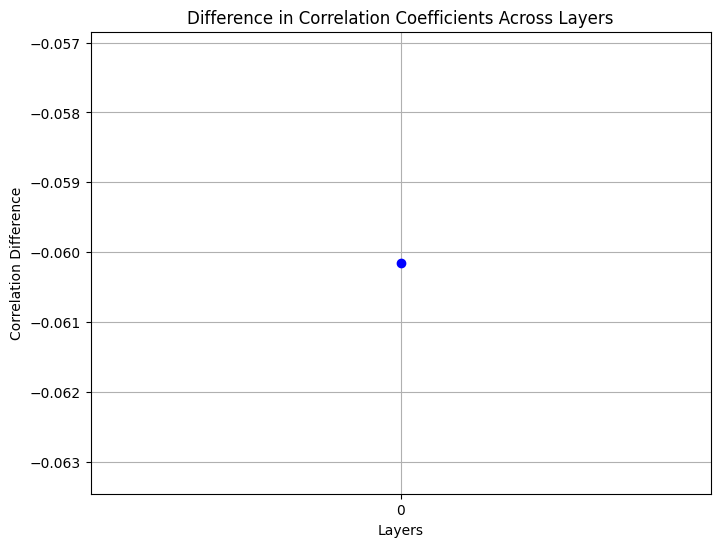

In [19]:
RC_across_layers = []
model = resnet
print()
features_length = extract_features(stim_length, model)


r_relativeL, r_absoluteL = check_webers_law(features_length, absolute_delta_L, relative_delta_L, "Euclidean")
RC_across_layers.append([r_relativeL, r_absoluteL])
# Intensity
features_intensity = extract_features(stim_intensity, vgg16)
r_relativeI, r_absoluteI = check_webers_law(features_intensity, absolute_delta_I, relative_delta_I, dist_type)
RC_across_layers.append([r_relativeI, r_absoluteI])
# print(RC_across_layers)

import matplotlib.pyplot as plt

# Assuming RC_across_layers is a list of lists containing correlation coefficients
# where RC_across_layers[i][0] represents one correlation coefficient and
# RC_across_layers[i][1] represents another correlation coefficient for the same layer 'i'

# Compute differences between correlation coefficients across layers
differences = RC_across_layers[0][0] - RC_across_layers[0][1]
print(differences)
# Create x-axis values (layers)
layers = range(len(differences))

# Plot the differences
plt.figure(figsize=(8, 6))
plt.plot(layers, differences, marker='o', linestyle='-', color='b')
plt.xlabel('Layers')
plt.ylabel('Correlation Difference')
plt.title('Difference in Correlation Coefficients Across Layers')
plt.grid(True)
plt.xticks(layers)  # Set x-ticks to be the layer indices
plt.show()



In [20]:
inception = models.inception_v3(pretrained=True)

/home/venix/miniconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/venix/miniconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/venix/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:23<00:00, 4.61MB/s] 


[0.15692122]


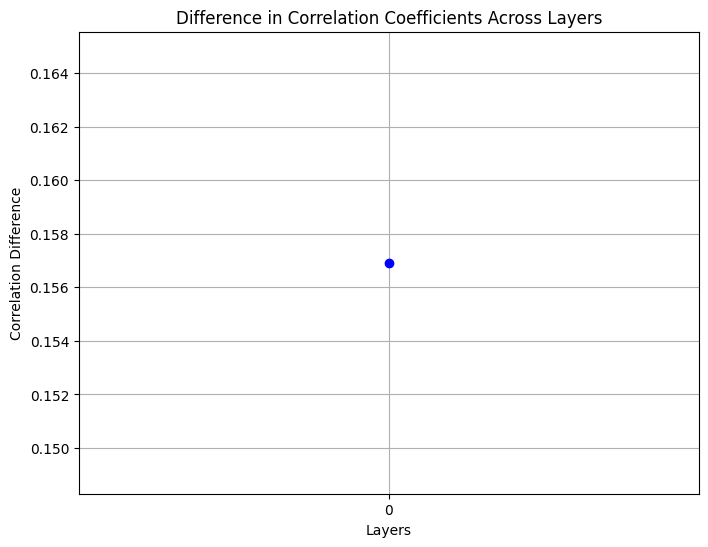

In [21]:
RC_across_layers = []
model = inception
features_length = extract_features(stim_length, model)


r_relativeL, r_absoluteL = check_webers_law(features_length, absolute_delta_L, relative_delta_L, "Euclidean")
RC_across_layers.append([r_relativeL, r_absoluteL])
# Intensity
features_intensity = extract_features(stim_intensity, vgg16)
r_relativeI, r_absoluteI = check_webers_law(features_intensity, absolute_delta_I, relative_delta_I, dist_type)
RC_across_layers.append([r_relativeI, r_absoluteI])
# print(RC_across_layers)

import matplotlib.pyplot as plt

# Assuming RC_across_layers is a list of lists containing correlation coefficients
# where RC_across_layers[i][0] represents one correlation coefficient and
# RC_across_layers[i][1] represents another correlation coefficient for the same layer 'i'

# Compute differences between correlation coefficients across layers
differences = RC_across_layers[0][0] - RC_across_layers[0][1]
print(differences)
# Create x-axis values (layers)
layers = range(len(differences))

# Plot the differences
plt.figure(figsize=(8, 6))
plt.plot(layers, differences, marker='o', linestyle='-', color='b')
plt.xlabel('Layers')
plt.ylabel('Correlation Difference')
plt.title('Difference in Correlation Coefficients Across Layers')
plt.grid(True)
plt.xticks(layers)  # Set x-ticks to be the layer indices
plt.show()

